In [1]:
# Setup and Data Loading
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')

# Clone repository if not exists and load data
if not os.path.exists('2155-Challenge-Problem-2'):
    import subprocess
    print("Cloning repository...")
    subprocess.run(['git', 'clone', 'https://github.com/Lyleregenwetter/2155-Challenge-Problem-2'], 
                   check=True, cwd='.')
    print("Repository cloned!")

# Change to the repository directory and load data
os.chdir('2155-Challenge-Problem-2')

# Import utilities
from utils_public import load_grids, plot_n_grids

print("Loading data...")
grids = load_grids()
ratings = np.load("datasets/scores.npy")

print(f"Grids shape: {grids.shape}")
print(f"Ratings shape: {ratings.shape}")
print(f"Available ratings per advisor: {(~np.isnan(ratings)).sum(axis=0)}")

# advisor_names = ["Wellness", "Tax", "Transportation", "Business"]

# Change back to parent directory for saving results
os.chdir('..')

Loading data...
Grids shape: (500000, 7, 7)
Ratings shape: (500000, 4)
Available ratings per advisor: [5000 5000 5000 5000]


In [2]:
# Reload the oracle module to get the latest changes
import importlib
import sys
if 'oracle' in sys.modules:
    importlib.reload(sys.modules['oracle'])
from oracle import CNNTaxOracle # TaxOracle

# Initialize Tax Oracle
tax_oracle = CNNTaxOracle()
print("Tax Oracle initialized!")

# Select grids and ratings for Tax advisor (not nan, index 1)
tax_index = 1
grids_subset = grids[~np.isnan(ratings[:, tax_index])]
ratings_subset = ratings[~np.isnan(ratings[:, tax_index]), tax_index]

# Get model scores
model_scores, train_data, test_data = tax_oracle.fit_model(grids_subset, ratings_subset)
print("Model Scores:", model_scores)

predictions = tax_oracle.predict(grids_subset)
print("Predictions shape:", predictions.shape)

🔥 PyTorch available, using device: cpu
Tax Oracle initialized!

Training PyTorch CNN Transportation Oracle
Available training samples: 5000
Training parameters:
  - Epochs: 100
  - Batch size: 128
  - Test size: 0.2
  - Learning rate: 0.0003
  - Model type: standard
  - Device: cpu
🔥 Using PyTorch CNN approach for spatial pattern recognition...
🏗️ CNN Architecture:
CityCNN1(
  (block1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace

Making predictions on train set...
🚛 Creating transportation predictions for 4000 grids...
Making predictions on test set...
🚛 Creating transportation predictions for 1000 grids...


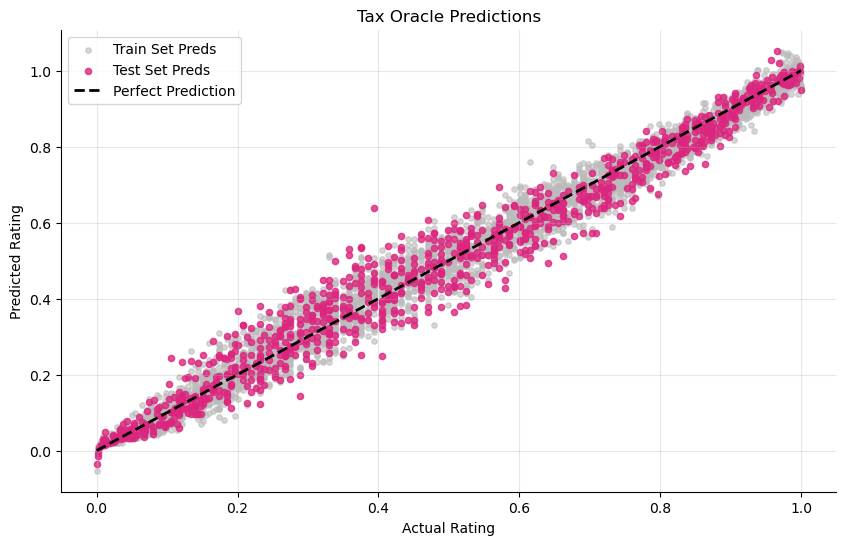

Tax Oracle Train Set R² score: 0.9803
Tax Oracle Test Set R² score: 0.9679

Model Performance Summary:
Training R²:   0.9803
Test R²:       0.9679
Overfitting:   No (0.0124)
Performance:   Excellent


In [3]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def plot_and_r2(preds_train, preds_test, ratings_train, ratings_test):
    #Create scatter plot
    plt.figure(figsize=(10,6))
    plt.scatter(ratings_train, preds_train, label='Train Set Preds', s=15, c="#BBBBBB", alpha=0.6) #train set in gray
    plt.scatter(ratings_test, preds_test, label='Test Set Preds', s=20, c="#DC267F", alpha=0.8) #test set in magenta
    plt.plot([0,1], [0,1], label="Perfect Prediction", linewidth=2, c="k", linestyle='--') #target line in black

    #Set axis labels and title
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title("Tax Oracle Predictions")

    #Turn off top and right spines
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.legend() #Display legend
    plt.grid(True, alpha=0.3)
    plt.show() #Show plot

    #Calculate R2 score for train and test sets
    train_r2 = r2_score(ratings_train, preds_train)
    test_r2 = r2_score(ratings_test, preds_test)
    
    print(f"Tax Oracle Train Set R² score: {train_r2:.4f}")
    print(f"Tax Oracle Test Set R² score: {test_r2:.4f}")
    
    return train_r2, test_r2

# For PyTorch CNN model, we need to recreate the train/test split and get predictions
# Use the same random state as used in the model training (42)
X_train, X_test, y_train, y_test = train_test_split(
    grids_subset, ratings_subset, test_size=0.2, random_state=42)

print("Making predictions on train set...")
preds_train = tax_oracle.predict(X_train)

print("Making predictions on test set...")
preds_test = tax_oracle.predict(X_test)

# Create the plot and get R² scores
train_r2, test_r2 = plot_and_r2(preds_train, preds_test, y_train, y_test)

# Additional analysis
print(f"\nModel Performance Summary:")
print(f"{'='*40}")
print(f"Training R²:   {train_r2:.4f}")
print(f"Test R²:       {test_r2:.4f}")
print(f"Overfitting:   {'Yes' if (train_r2 - test_r2) > 0.1 else 'No'} ({train_r2 - test_r2:.4f})")
print(f"Performance:   {'Excellent' if test_r2 > 0.9 else 'Good' if test_r2 > 0.8 else 'Fair' if test_r2 > 0.6 else 'Poor'}")

In [4]:
# save model in pkl file
tax_oracle.save_model('tax_oracle_model.pkl')

# --- IGNORE ---
# instructions on how to use exported model
# from oracle import BusinessOracle
# business_oracle = BusinessOracle.load_model("business_oracle_model.pkl")
# --- IGNORE ---

💾 Saved PyTorch model to tax_oracle_model_pytorch.pth and metadata to tax_oracle_model.pkl
